In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pwd

/home/rene/Development/LLM/z/scratch-llm


In [1]:
import sys

sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
import torch

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig, get_device


print(f"pytorch version: {torch.__version__}")

pytorch version: 2.1.0.post301


In [2]:
llm_config = LLMConfig(
    vocab_size=18_000, # 2_000
    context_size=256, # 64
    dim_emb=3072, # 256
    num_layers=7, # 4
    num_heads=8,
    emb_dropout=0.0,
    ffd_dim_hidden=4 * 512,
    ffd_bias=False,
)

train_config = TrainingConfig(
    retrain_tokenizer=False,
    device=get_device(),
    batch_size=32, # 64
    learning_rate=3e-4,
    weight_decay=1e-5,
    max_steps=1000, # 3_000, # 4_000
    log_frequency=1,
)

In [3]:
input_file = "data/shakespeare/simonyi.txt"
output_file = Path(input_file).with_suffix(".model")

if not output_file.exists() or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size)

tokenizer = Tokenizer(str(output_file))

In [4]:
tokenizer.sp.encode("auf")

[34]

In [5]:
sentence = (
    "The role of the tokenizer is to build a mapping between a sentences represented as a string and token indices"
)
print(tokenizer.sp.EncodeAsPieces(sentence))

assert tokenizer.decode(tokenizer.encode(sentence)) == sentence

['▁The', '▁', 'ro', 'le', '▁of', '▁the', '▁t', 'o', 'k', 'en', 'iz', 'er', '▁', 'is', '▁t', 'o', '▁b', 'u', 'il', 'd', '▁a', '▁', 'ma', 'pp', 'ing', '▁be', 't', 'w', 'e', 'en', '▁a', '▁s', 'en', 'ten', 'c', 'es', '▁re', 'p', 'r', 'es', 'en', 'te', 'd', '▁a', 's', '▁a', '▁', 'st', 'ring', '▁', 'and', '▁t', 'o', 'k', 'en', '▁in', 'd', 'ic', 'es']


In [6]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)

X, y = ds_train.get_batch(batch_size=8)

print(X.shape, y.shape)

torch.Size([8, 256]) torch.Size([8, 256])


In [7]:
model = LLM(
    vocab_size=tokenizer.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
    emb_dropout=llm_config.emb_dropout,
    ffd_hidden_dim=llm_config.ffd_dim_hidden,
    ffd_bias=llm_config.ffd_bias,
)

params_size = sum(p.nelement() * p.element_size() for p in model.parameters())
buffer_size = sum(p.nelement() * p.element_size() for p in model.buffers())
size = (params_size + buffer_size) / 1024**2

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"model size: {size:.3f}MB")

# print(model)

total params: 423,406,544
model size: 1620.855MB


In [8]:
loss_history = train(
    model,
    ds_train,
    train_config.device,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    weight_decay=train_config.weight_decay,
    log_every=train_config.log_frequency,
)

Training on cuda.


/home/rene/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


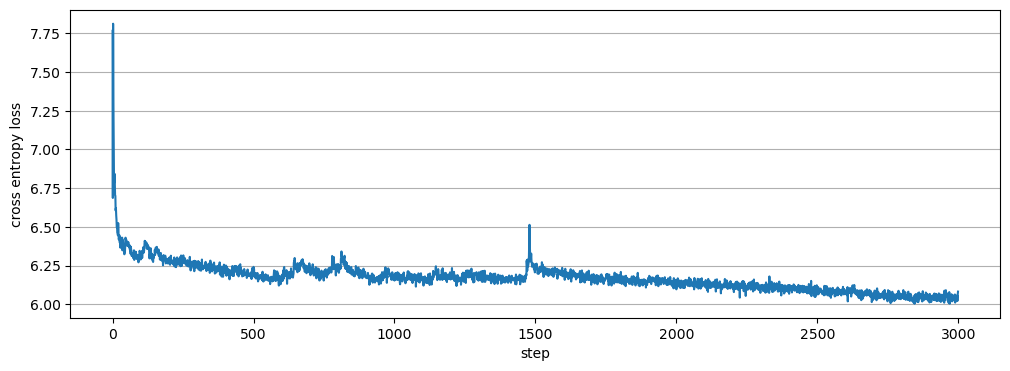

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

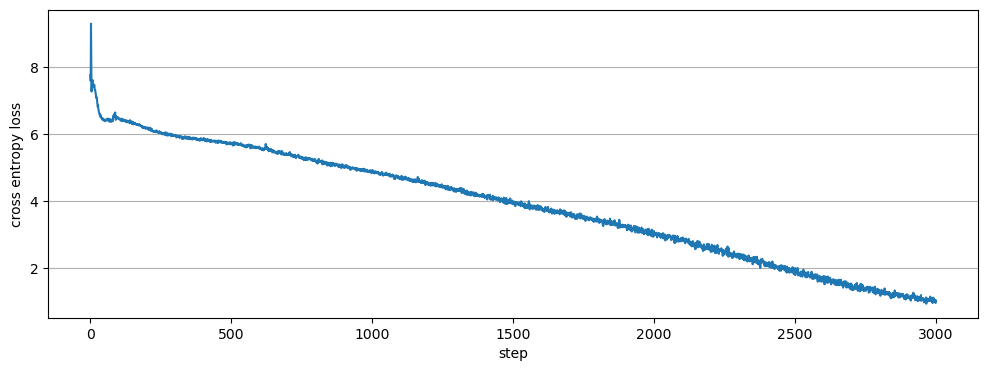

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

In [17]:
# empty prompt to generate random stuff
prompt = torch.full((1, llm_config.context_size), tokenizer.pad_id, dtype=torch.int32).to(train_config.device)
out = model.generate(prompt, max_seq_len=30)
tokenizer.decode(out)

'schlossen wurde. an der Jahrtausend wichtign vor sich gehen, daß ein g2 einfallenden Energie immerein großer Teilchen in'

In [18]:
# generate from a prompt
prompt = (
    tokenizer.encode(
        "Schrödingers Gleichung beinhaltet ",
        beg_of_string=True,
        pad_seq=True,
        seq_len=llm_config.context_size,
    )
    .view(1, -1)
    .to(train_config.device)
)
out = model.generate(prompt, max_seq_len=30)
tokenizer.decode(out)

'Schrödingers Gleichung beinhaltet sie - 1990 mit Resperfung theoretischand die Erlebung Rutherforder geformt, an die wir, eine von den'

In [14]:
out

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [15]:
!ls -al data/shakespeare/ti*


-rw-rw-r-- 1 rene rene  269703 Mär 30 20:16 data/shakespeare/tinyshakespeare.model
-rw-rw-r-- 1 rene rene 1115393 Mär 30 20:16 data/shakespeare/tinyshakespeare.txt
-rw-rw-r-- 1 rene rene   33763 Mär 30 20:16 data/shakespeare/tinyshakespeare.vocab


In [16]:
AT0010000000000000001000001713033

NameError: name 'AT0010000000000000001000001713033' is not defined